In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import eda_util
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from imputers import *
from lightgbm import LGBMRegressor

c:\Users\User\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
random_state = 64
target = 'delivery_time'

# Loading data

In [4]:
def load_data(path):
    df = pd.read_csv(path, index_col=0)
    dtc = eda_util.ColumnTransformers.DatatimeConverter(columns=['created_at', 'actual_delivery_time'], format='%Y-%m-%d %H:%M:%S')
    df = dtc.fit_transform(df)
    return df

In [8]:
train_csv = load_data('../datasets/train.csv')
train_csv.info()
train_csv.head()

<class 'pandas.core.frame.DataFrame'>
Index: 177678 entries, 106702 to 39366
Data columns (total 18 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     176792 non-null  float64       
 1   created_at                                    177678 non-null  datetime64[ns]
 2   actual_delivery_time                          177678 non-null  datetime64[ns]
 3   store_id                                      177678 non-null  int64         
 4   store_primary_category                        173394 non-null  object        
 5   order_protocol                                176765 non-null  float64       
 6   total_items                                   177678 non-null  int64         
 7   subtotal                                      177678 non-null  int64         
 8   num_distinct_items                            177678 no

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_hours,delivery_time
106702,4.0,2015-02-04 22:44:19,2015-02-04 23:16:17,6717,dessert,5.0,6,4770,5,795,795,9.0,12.0,15.0,251,407.0,22,1918.0
59877,4.0,2015-01-28 05:05:05,2015-01-28 06:11:26,2119,turkish,3.0,2,2098,2,999,1099,27.0,27.0,30.0,251,817.0,5,3981.0
88918,2.0,2015-01-24 00:51:19,2015-01-24 01:39:37,6563,steak,5.0,5,3696,4,0,1399,39.0,27.0,28.0,251,530.0,0,2898.0
112561,2.0,2015-02-18 03:29:26,2015-02-18 04:05:53,6821,sandwich,5.0,3,2147,2,235,679,99.0,64.0,108.0,251,834.0,3,2187.0
161617,1.0,2015-02-11 01:51:20,2015-02-11 03:07:53,400,japanese,1.0,1,3800,1,3800,3800,40.0,40.0,45.0,446,534.0,1,4593.0


In [9]:
test_csv = load_data('../datasets//test.csv')
test_csv.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_hours,delivery_time
119152,4.0,2015-01-25 19:45:36,2015-01-25 20:07:18,3597,american,3.0,4,2140,4,275,1125,47.0,92.0,38.0,251,169.0,19,1302.0
10465,4.0,2015-02-13 19:06:41,2015-02-13 19:49:10,2664,dessert,3.0,2,1370,2,475,895,9.0,2.0,3.0,251,748.0,19,2549.0
95349,3.0,2015-01-25 02:27:17,2015-01-25 03:33:46,808,american,1.0,3,1767,3,199,749,24.0,24.0,26.0,446,784.0,2,3989.0
178586,4.0,2015-02-11 02:23:12,2015-02-11 03:22:30,5341,vietnamese,5.0,2,1275,2,300,875,82.0,75.0,119.0,251,938.0,2,3558.0
169841,4.0,2015-02-11 02:16:46,2015-02-11 02:56:33,3251,indian,2.0,10,1461,7,0,399,NaN,NaN,NaN,251,386.0,2,2387.0


# Train-Test Split

In [10]:
X_train, y_train = eda_util.feature_target.feature_target_split(train_csv, target=target)
X_test, y_test = eda_util.feature_target.feature_target_split(test_csv, target=target)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (177678, 17)
Shape of y_train: (177678,)
Shape of X_test: (19743, 17)
Shape of y_test: (19743,)


# Categorical Encodings

In [11]:
market_features = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
cat_features = ['market_id', 'store_id', 'order_protocol', 'store_primary_category']

## LGBM Encoder

In [12]:
class LGBMEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None) -> None:
        self.columns = columns
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[self.columns] = self.encoder.transform(X[self.columns])
        return X

In [13]:
encoder_lgb = Pipeline(
    [
        ('imputer', Imputers(market_features=market_features)),
        ('label_encoder', LGBMEncoder(columns='store_primary_category'))
    ]
)

# Model exploration

In [14]:
class ColumnDropper():
    def __init__(self, columns) -> None:
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

In [15]:
preprocess_pipe = Pipeline(
    [
        ('market_id', MarketIDImputer()),
        ('primary_category', PrimaryCategoryImputer()),
        ('market_features_median', MarketFeatureImputer(method='median', market_features=market_features)),
        ('market_features_nearest', MarketFeatureImputer(method='nearest', market_features=market_features)),
        ('label_encoder', LGBMEncoder(columns='store_primary_category')),
        ('drop_datetime', ColumnDropper(columns=['created_at', 'actual_delivery_time'])),
    ]
)

preprocess_pipe

Pipeline(steps=[('market_id',
                 <imputers.MarketIDImputer object at 0x0000018CACDE15D0>),
                ('primary_category',
                 <imputers.PrimaryCategoryImputer object at 0x0000018CACDE1090>),
                ('market_features_median',
                 <imputers.MarketFeatureImputer object at 0x0000018CACDE1450>),
                ('market_features_nearest',
                 <imputers.MarketFeatureImputer object at 0x0000018CACDE0A50>),
                ('label_encoder',
                 LGBMEncoder(columns='store_primary_category')),
                ('drop_datetime',
                 <__main__.ColumnDropper object at 0x0000018CACDE16D0>)])

## Base Model

### Preprocessing

In [12]:
X_train, y_train = eda_util.feature_target.feature_target_split(train_csv, target=target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1 / 9, random_state=random_state)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (157936, 17)
Shape of y_train: (157936,)
Shape of X_val: (19742, 17)
Shape of y_val: (19742,)
Shape of X_test: (19743, 17)
Shape of y_test: (19743,)


In [13]:
X_train_preprocessed = preprocess_pipe.fit_transform(X_train)
X_val_preprocessed = preprocess_pipe.transform(X_val)

d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')
d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


In [14]:
base_model = LGBMRegressor(random_state=random_state)
base_model.fit(X_train_preprocessed, y_train, eval_set=(X_val_preprocessed, y_val), categorical_feature=cat_features)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7214
[LightGBM] [Info] Number of data points in the train set: 157936, number of used features: 15
[LightGBM] [Info] Start training from score 2860.532627


LGBMRegressor(random_state=64)

In [15]:
print('RMSE for training set:', rmse(base_model.predict(X_train_preprocessed), y_train))
print('RMSE for validation set:', rmse(base_model.predict(X_val_preprocessed), y_val))

RMSE for training set: 903.341265437906
RMSE for validation set: 972.587237272343


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

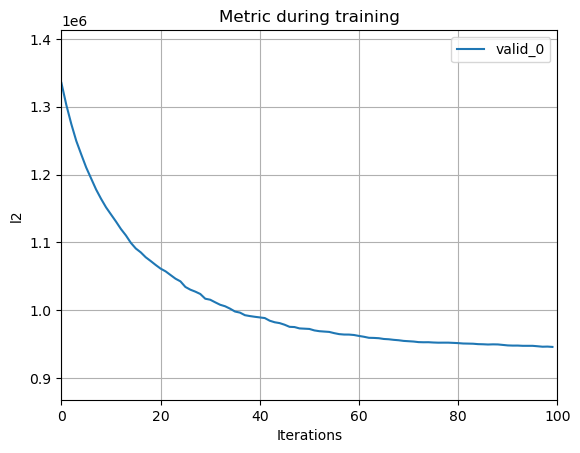

In [16]:
lgb.plot_metric(base_model)

Text(0.5, 1.0, 'Feature importance of base_model (Gain)')

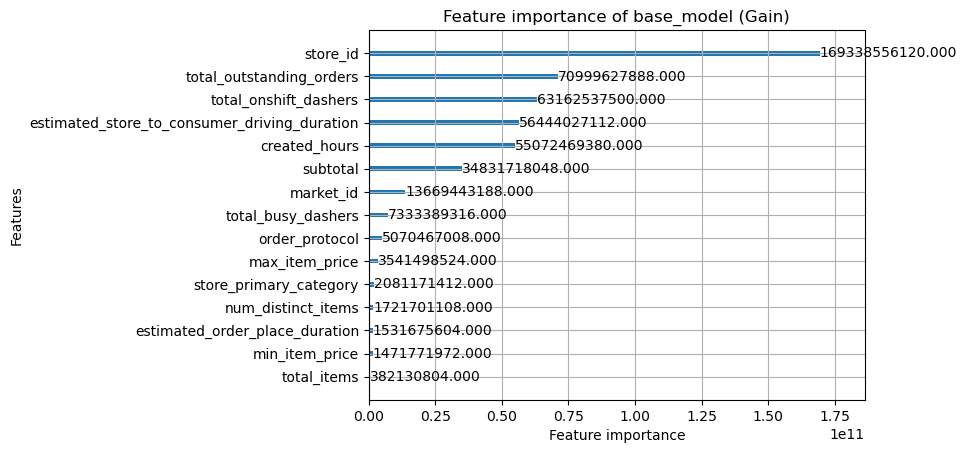

In [17]:
lgb.plot_importance(base_model, importance_type='gain').set_title('Feature importance of base_model (Gain)')

In [18]:
print('RMSE for test set:', rmse(base_model.predict(preprocess_pipe.transform(X_test)), y_test))

RMSE for test set: 963.0338172292286


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


### Error analysis

In [19]:
def error_analysis(model, X_train, y_train, X_val=None, y_val=None, verbose=True) -> pd.DataFrame:
    # Training set errors
    model_train_error_df = abs(model.predict(X_train) - y_train).rename('abs_error').to_frame()
    model_train_error_df['actual_delivery_time'] = y_train
    model_train_error_df['rel_error'] = model_train_error_df['abs_error'] / model_train_error_df['actual_delivery_time']
    model_train_error_df['set'] = 'Train'

    # Validation set errors
    model_val_error_df = abs(model.predict(X_val) - y_val).rename('abs_error').to_frame()
    model_val_error_df['actual_delivery_time'] = y_val
    model_val_error_df['rel_error'] = model_val_error_df['abs_error'] / model_val_error_df['actual_delivery_time']
    model_val_error_df['set'] = 'Val'

    model_error_df = pd.concat([model_train_error_df, model_val_error_df])

    if verbose:
        display(model_error_df.groupby('set')['abs_error'].describe().T)

    return model_error_df

#### Training and Validation sets errors

In [20]:
base_model_error_df = error_analysis(base_model, X_train_preprocessed, y_train, X_val_preprocessed, y_val, verbose=True)

set,Train,Val
count,157936.000000,19742.000000
mean,595.012454,638.813803
std,679.697393,733.396281
min,0.005605,0.063182
25%,221.208527,241.948447
50%,461.754396,494.460658
75%,782.085736,833.344793
max,48248.851442,45279.191211


#### Error distribution

Text(0.5, 1.0, 'Absolute Error distribution')

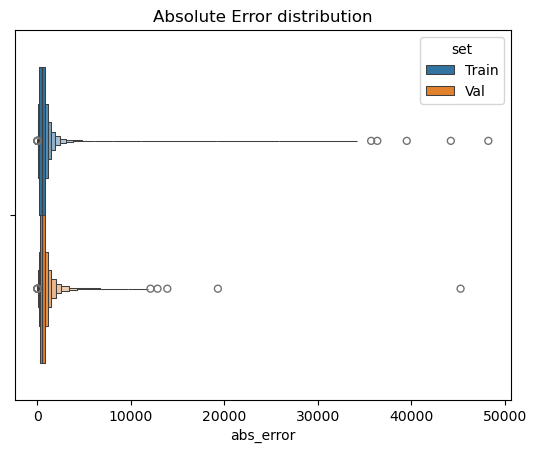

In [21]:
sns.boxenplot(base_model_error_df, x='abs_error', hue='set').set_title('Absolute Error distribution')

Text(0.5, 1.0, 'Absolute Error distribution')

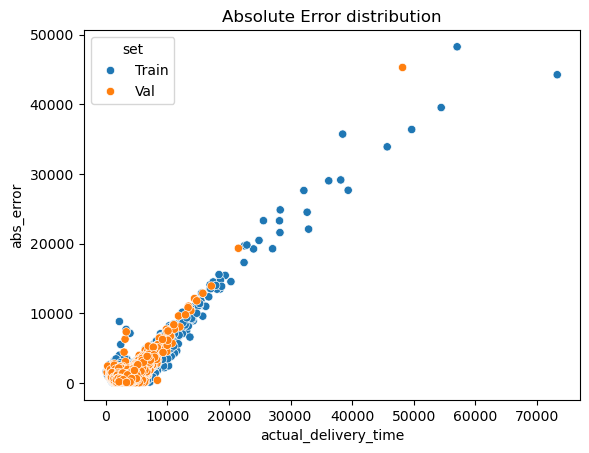

In [22]:
sns.scatterplot(base_model_error_df, x='actual_delivery_time', y='abs_error', hue='set').set_title('Absolute Error distribution')

In [23]:
print('Relative error for training set:', base_model_error_df.loc[base_model_error_df['set'] == 'Train', 'rel_error'].mean())

Relative error for training set: 0.22098552048576137


In [24]:
print('Relative error for test set:', np.mean(np.abs(base_model.predict(preprocess_pipe.transform(X_test)) - y_test) / y_test))

Relative error for test set: 0.23830818374326573


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


## Base Model (Removing outliers)

### train_test_split and removing outliers

In [25]:
from numpy import ndarray


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, zscore=2) -> None:
        self.zscore = zscore
        self.mean = 0
        self.stddev = 0
    
    def fit(self, X, y):
        self.mean = y.mean()
        self.stddev = np.std(np.array(y, dtype=np.float64), dtype=np.float64)
        return self

    def transform(self, X, y):
        self.index = (y[np.abs((y - self.mean) / self.stddev) < self.zscore]).index
        X, y = X.copy(), y.copy()
        X = X.loc[self.index]
        y = y[self.index]
        return X, y
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        X, y = self.transform(X, y)
        return X, y
    

In [26]:
X_train, y_train = eda_util.feature_target.feature_target_split(train_csv, target=target)

X_train_preprocessed = preprocess_pipe.fit_transform(X_train)

outlier_remover = OutlierRemover(zscore=2)

X_train_preprocessed, y_train = outlier_remover.fit_transform(X_train_preprocessed, y_train)

X_train_preprocessed, X_val_preprocessed, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size = 1 / 9, random_state=random_state)

print('Shape of X_train:', X_train_preprocessed.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val_preprocessed.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (152561, 15)
Shape of y_train: (152561,)
Shape of X_val: (19071, 15)
Shape of y_val: (19071,)
Shape of X_test: (19743, 17)
Shape of y_test: (19743,)


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


In [27]:
base_model_no_outliers = lgb.LGBMRegressor(random_state=random_state)
base_model_no_outliers.fit(X_train_preprocessed, y_train, eval_set=(X_val_preprocessed, y_val), categorical_feature=cat_features)
print('RMSE for training set:', rmse(base_model_no_outliers.predict(X_train_preprocessed), y_train))
print('RMSE for validation set:', rmse(base_model_no_outliers.predict(X_val_preprocessed), y_val))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7108
[LightGBM] [Info] Number of data points in the train set: 152561, number of used features: 15
[LightGBM] [Info] Start training from score 2733.935049
RMSE for training set: 643.5303931814764
RMSE for validation set: 694.301356947646


### Test set result

In [28]:
print('RMSE for test set:', rmse(base_model_no_outliers.predict(preprocess_pipe.transform(X_test)), y_test))

RMSE for test set: 974.9839101593617


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


Text(0.5, 1.0, 'Feature importance of base_model_no_outliers (Gain)')

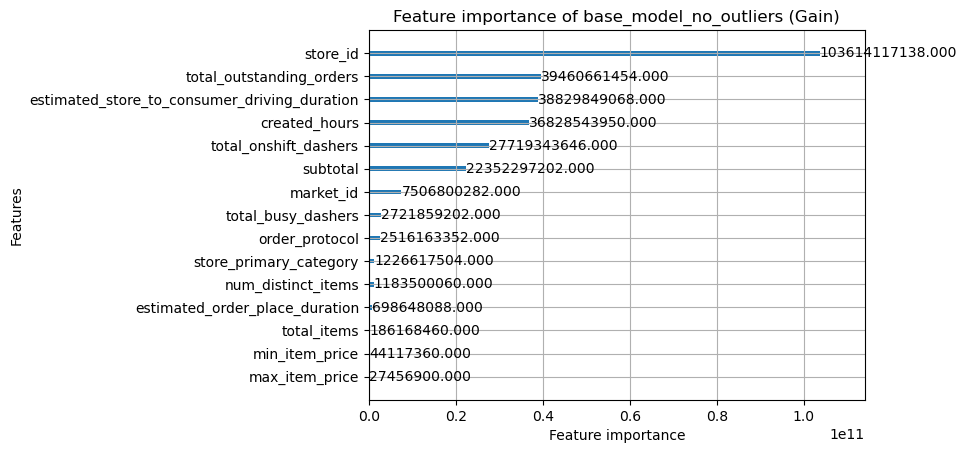

In [29]:
lgb.plot_importance(base_model_no_outliers, importance_type='gain').set_title('Feature importance of base_model_no_outliers (Gain)')

### Error Analysis

#### Training and Validation sets errors

In [30]:
base_model_no_outliers_error_df = error_analysis(base_model_no_outliers, X_train_preprocessed, y_train, X_val_preprocessed, y_val)

set,Train,Val
count,152561.000000,19071.000000
mean,504.119802,545.731510
std,399.994551,429.233216
min,0.002941,0.046194
25%,200.483062,219.277278
50%,418.457753,455.238741
75%,705.228110,769.002384
max,3217.806141,3275.479604


#### Error distribution

<Axes: xlabel='abs_error'>

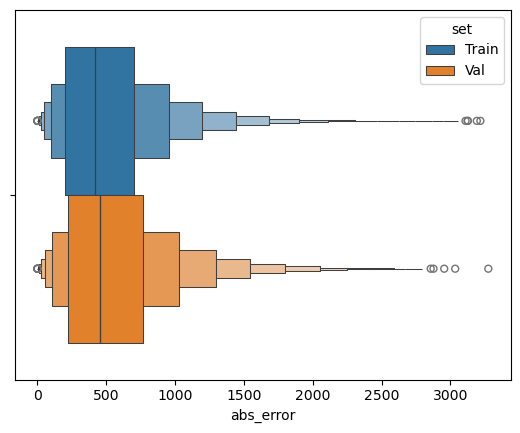

In [31]:
sns.boxenplot(base_model_no_outliers_error_df, x='abs_error', hue='set')

Text(0.5, 1.0, 'Absolute Error distribution')

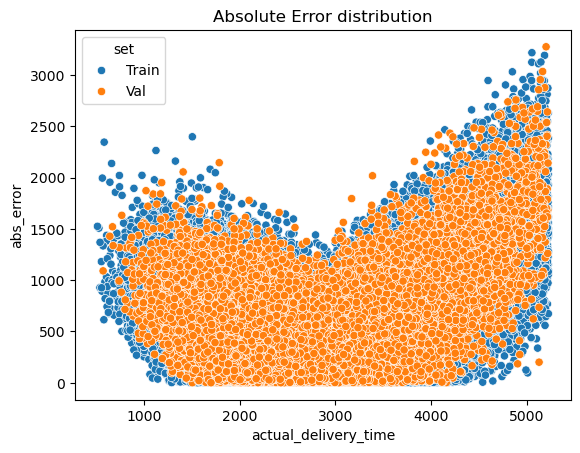

In [32]:
sns.scatterplot(base_model_no_outliers_error_df, x='actual_delivery_time', y='abs_error', hue='set').set_title('Absolute Error distribution')

In [33]:
print('Relative error for training set:', base_model_no_outliers_error_df.loc[base_model_no_outliers_error_df['set'] == 'Train', 'rel_error'].mean())
print('Relative error for validation set:', base_model_no_outliers_error_df.loc[base_model_no_outliers_error_df['set'] == 'Val', 'rel_error'].mean())

Relative error for training set: 0.20103247355502712
Relative error for validation set: 0.21579688599833827


In [34]:
print('Relative error for test set:', np.mean(np.abs(base_model.predict(preprocess_pipe.transform(X_test)) - y_test) / y_test))

Relative error for test set: 0.23830263550603414


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


# Bayesian Search CV

In [17]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold

## train_test_split

In [18]:
X_train, y_train = eda_util.feature_target.feature_target_split(train_csv, target=target)
X_test, y_test = eda_util.feature_target.feature_target_split(test_csv, target=target)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (177678, 17)
Shape of y_train: (177678,)
Shape of X_test: (19743, 17)
Shape of y_test: (19743,)


## Without removing outlier

In [24]:
X_train_preprocessed = preprocess_pipe.fit_transform(X_train)

d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\model_building\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


In [32]:
store_primary_category_encode = {preprocess_pipe['label_encoder'].encoder.classes_[i]: i for i in range(len(preprocess_pipe['label_encoder'].encoder.classes_))}

import json
# Convert and write JSON object to file
with open("store_primary_category_encode.json", "w") as outfile: 
    json.dump(store_primary_category_encode, outfile)

In [38]:
# kf = KFold(n_splits = 10, shuffle = True, random_state = random_state)        # Construct a 10-fold shuffler
# reg = lgb.LGBMRegressor(random_state=1048576, verbose=-1)                    # Base estimator
# opt = BayesSearchCV(reg,                                                      # Param Space
#                     {
#                         "max_depth": Integer(3, 13),
#                         "num_leaves": Integer(20, 200),
#                         "min_child_samples": Integer(7, 75),
#                         "colsample_bytree": Real(0.25, 1),
#                         "subsample": Real(0.25, 1),
#                         "subsample_freq": Integer(1, 50),
#                         "reg_alpha": Real(0, 1),
#                         "reg_lambda": Real(0, 1),
#                         "min_split_gain": Real(0, 0.5)
#                     },
#                     n_iter = 150,
#                     cv = kf,
#                     n_jobs = 3,
#                     random_state = random_state,
#                     fit_params={"categorical_feature": cat_features},         # Passing categorical features to LGBMClassifier
#                    )
# opt

In [39]:
# opt.fit(X_train_preprocessed, y_train)

# best_lgb = opt.best_estimator_
# display(best_lgb)

# print(f'Best parameters are {opt.best_params_}')
# print(f'Best score is {opt.best_score_}')

Best parameters are OrderedDict([('colsample_bytree', 0.700757141907958), ('max_depth', 13), ('min_child_samples', 75), ('min_split_gain', 0.5), ('num_leaves', 200), ('reg_alpha', 1.0), ('reg_lambda', 1.0), ('subsample', 1.0), ('subsample_freq', 50)])
Best score is 0.30654259181023824

In [40]:
best_lgb = lgb.LGBMRegressor(
    colsample_bytree=0.700757141907958,
    max_depth=13,
    min_child_samples=75,
    min_split_gain=0.5,
    num_leaves=200,
    reg_alpha=1.0,
    reg_lambda=1.0,
    subsample=1.0,
    subsample_freq=50,
    random_state=1048576, 
    verbose=-1)

best_lgb.fit(X_train_preprocessed, y_train)

print(f'Train RMSE = {rmse(best_lgb.predict(X_train_preprocessed), y_train)}')


Train RMSE = 915.3691330390643


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

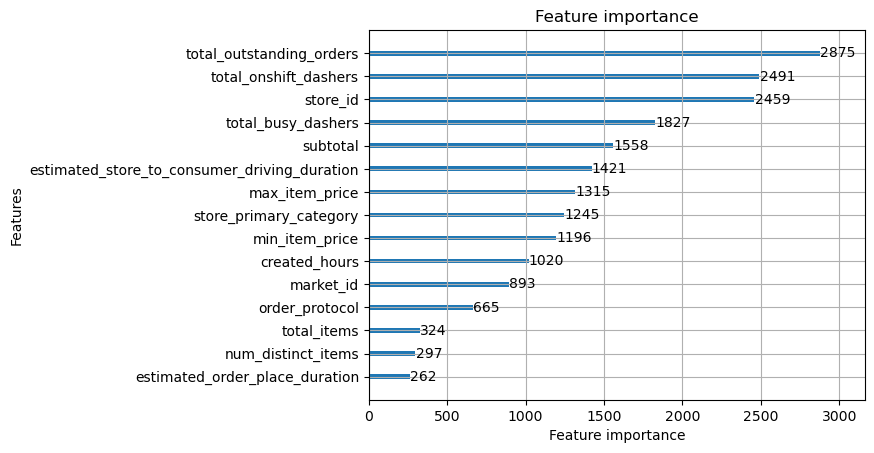

In [41]:
lgb.plot_importance(best_lgb)

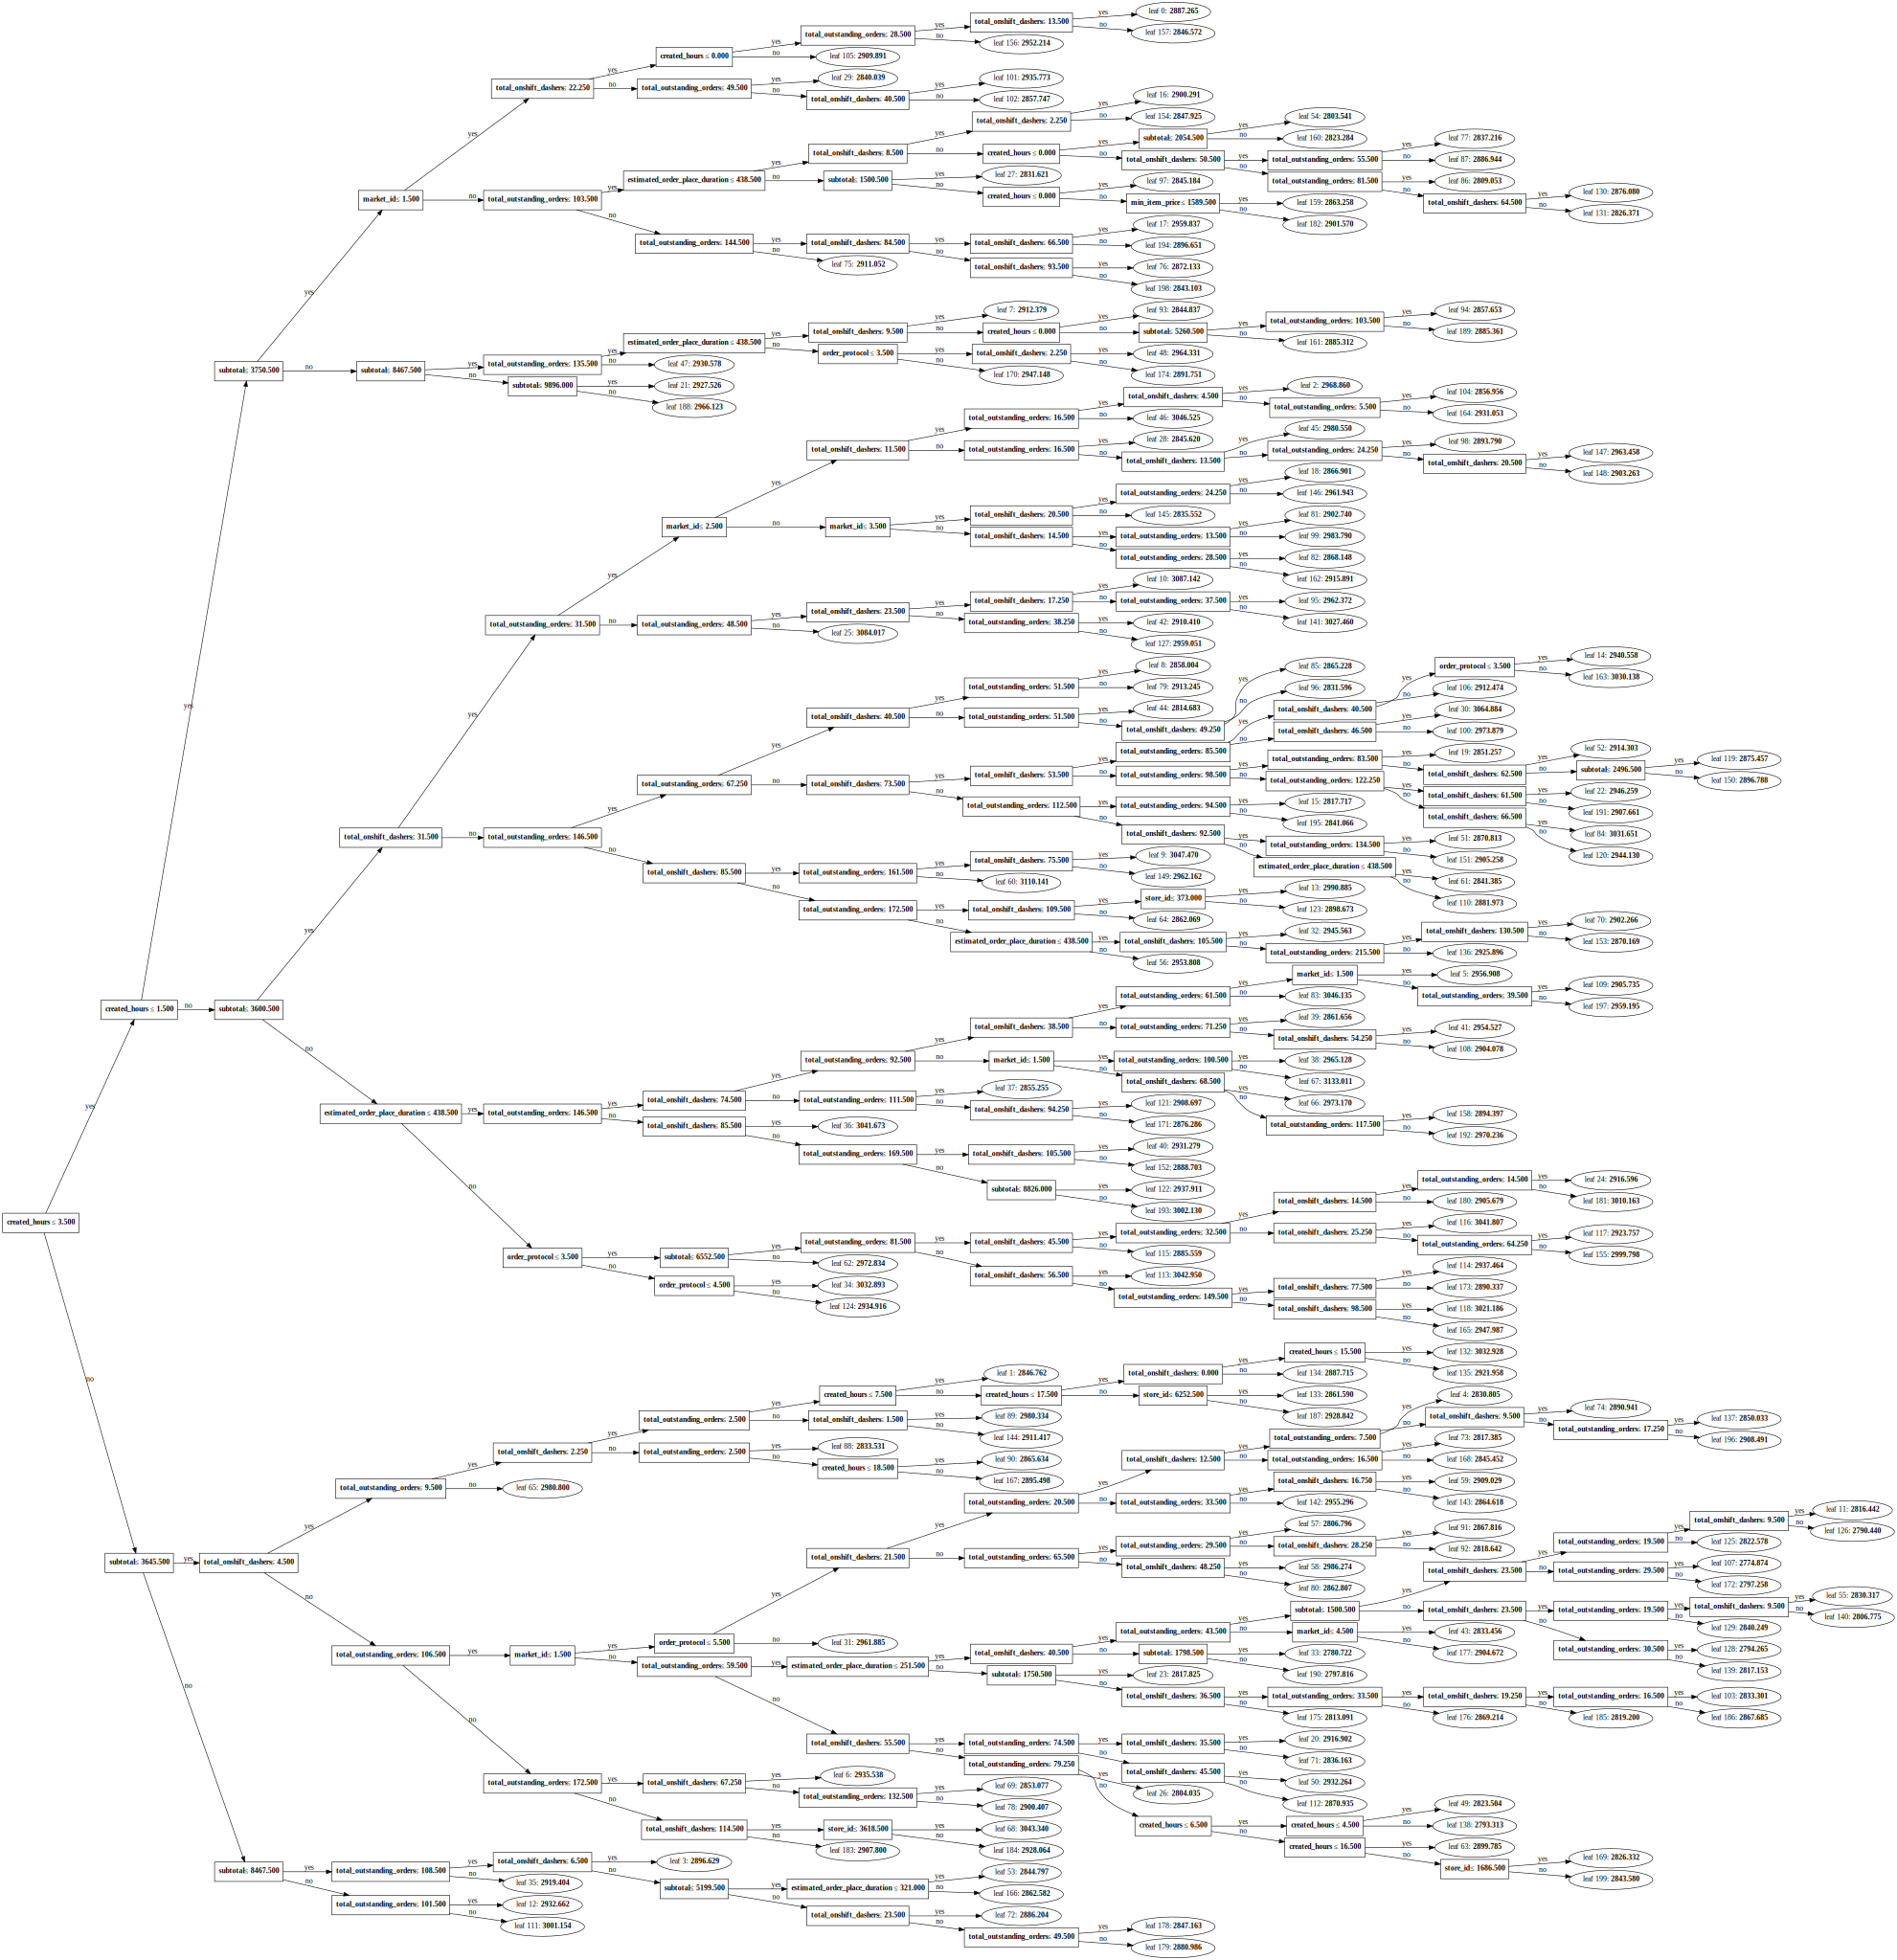

In [42]:
lgb.create_tree_digraph(best_lgb)

In [43]:
print(f'Test RMSE = {rmse(best_lgb.predict(preprocess_pipe.transform(X_test)), y_test)}')

Test RMSE = 956.1083487312169


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


## Removing outlier

In [47]:
X_train_preprocessed = preprocess_pipe.fit_transform(X_train)
X_train_preprocessed, y_train = outlier_remover.fit_transform(X_train_preprocessed, y_train)

d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


In [48]:
kf = KFold(n_splits = 10, shuffle = True, random_state = random_state)        # Construct a 10-fold shuffler
reg_ro = lgb.LGBMRegressor(random_state=1048576, verbose=-1)                    # Base estimator
opt_ro = BayesSearchCV(reg_ro,                                                      # Param Space
                    {
                        "max_depth": Integer(3, 13),
                        "num_leaves": Integer(20, 200),
                        "min_child_samples": Integer(7, 75),
                        "colsample_bytree": Real(0.25, 1),
                        "subsample": Real(0.25, 1),
                        "subsample_freq": Integer(1, 50),
                        "reg_alpha": Real(0, 1),
                        "reg_lambda": Real(0, 1),
                        "min_split_gain": Real(0, 0.5)
                    },
                    n_iter = 150,
                    cv = kf,
                    n_jobs = 3,
                    random_state = random_state,
                    fit_params={"categorical_feature": cat_features},         # Passing categorical features to LGBMClassifier
                   )
opt_ro

BayesSearchCV(cv=KFold(n_splits=10, random_state=64, shuffle=True),
              estimator=LGBMRegressor(random_state=1048576, verbose=-1),
              fit_params={'categorical_feature': ['market_id', 'store_id',
                                                  'order_protocol',
                                                  'store_primary_category']},
              n_iter=150, n_jobs=3, random_state=64,
              search_spaces={'colsample_bytree': Real(low=0.25, high=1, prior='uniform', transform='identity...
                             'num_leaves': Integer(low=20, high=200, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'subsample': Real(low=0.25, high=1, prior='uniform', transform='identity'),
                             'subsample_freq': Integer(low=1, high=50, prior='uniform', transform='identity')})

In [49]:
opt_ro.fit(X_train_preprocessed, y_train)

best_lgb_ro = opt_ro.best_estimator_
display(best_lgb_ro)

print(f'Best parameters are {opt_ro.best_params_}')
print(f'Best score is {opt_ro.best_score_}')

LGBMRegressor(max_depth=13, min_child_samples=75, num_leaves=200,
              random_state=1048576, reg_alpha=0.8207185914062756,
              reg_lambda=1.0, subsample_freq=27, verbose=-1)

Best parameters are OrderedDict([('colsample_bytree', 1.0), ('max_depth', 13), ('min_child_samples', 75), ('min_split_gain', 0.0), ('num_leaves', 200), ('reg_alpha', 0.8207185914062756), ('reg_lambda', 1.0), ('subsample', 1.0), ('subsample_freq', 27)])
Best RMSE score is 0.3635546405687201


Best parameters are OrderedDict([('colsample_bytree', 1.0), ('max_depth', 13), ('min_child_samples', 75), ('min_split_gain', 0.0), ('num_leaves', 200), ('reg_alpha', 0.8207185914062756), ('reg_lambda', 1.0), ('subsample', 1.0), ('subsample_freq', 27)])
Best RMSE score is 0.3635546405687201

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

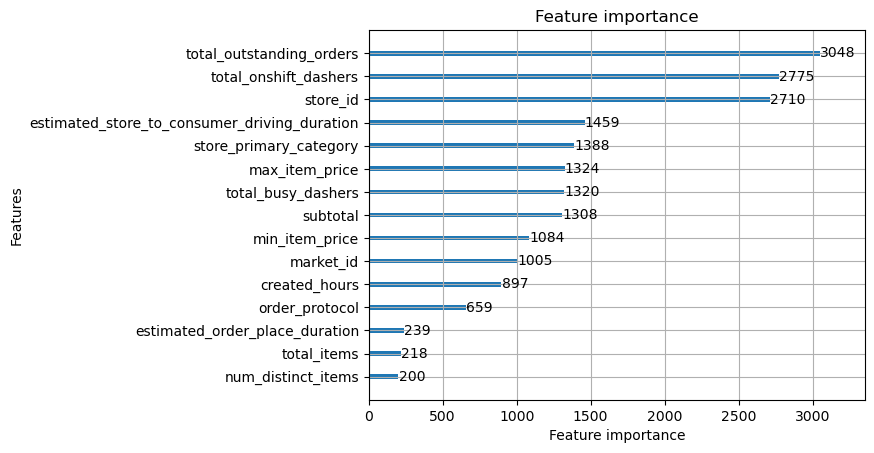

In [50]:
lgb.plot_importance(opt_ro.best_estimator_)

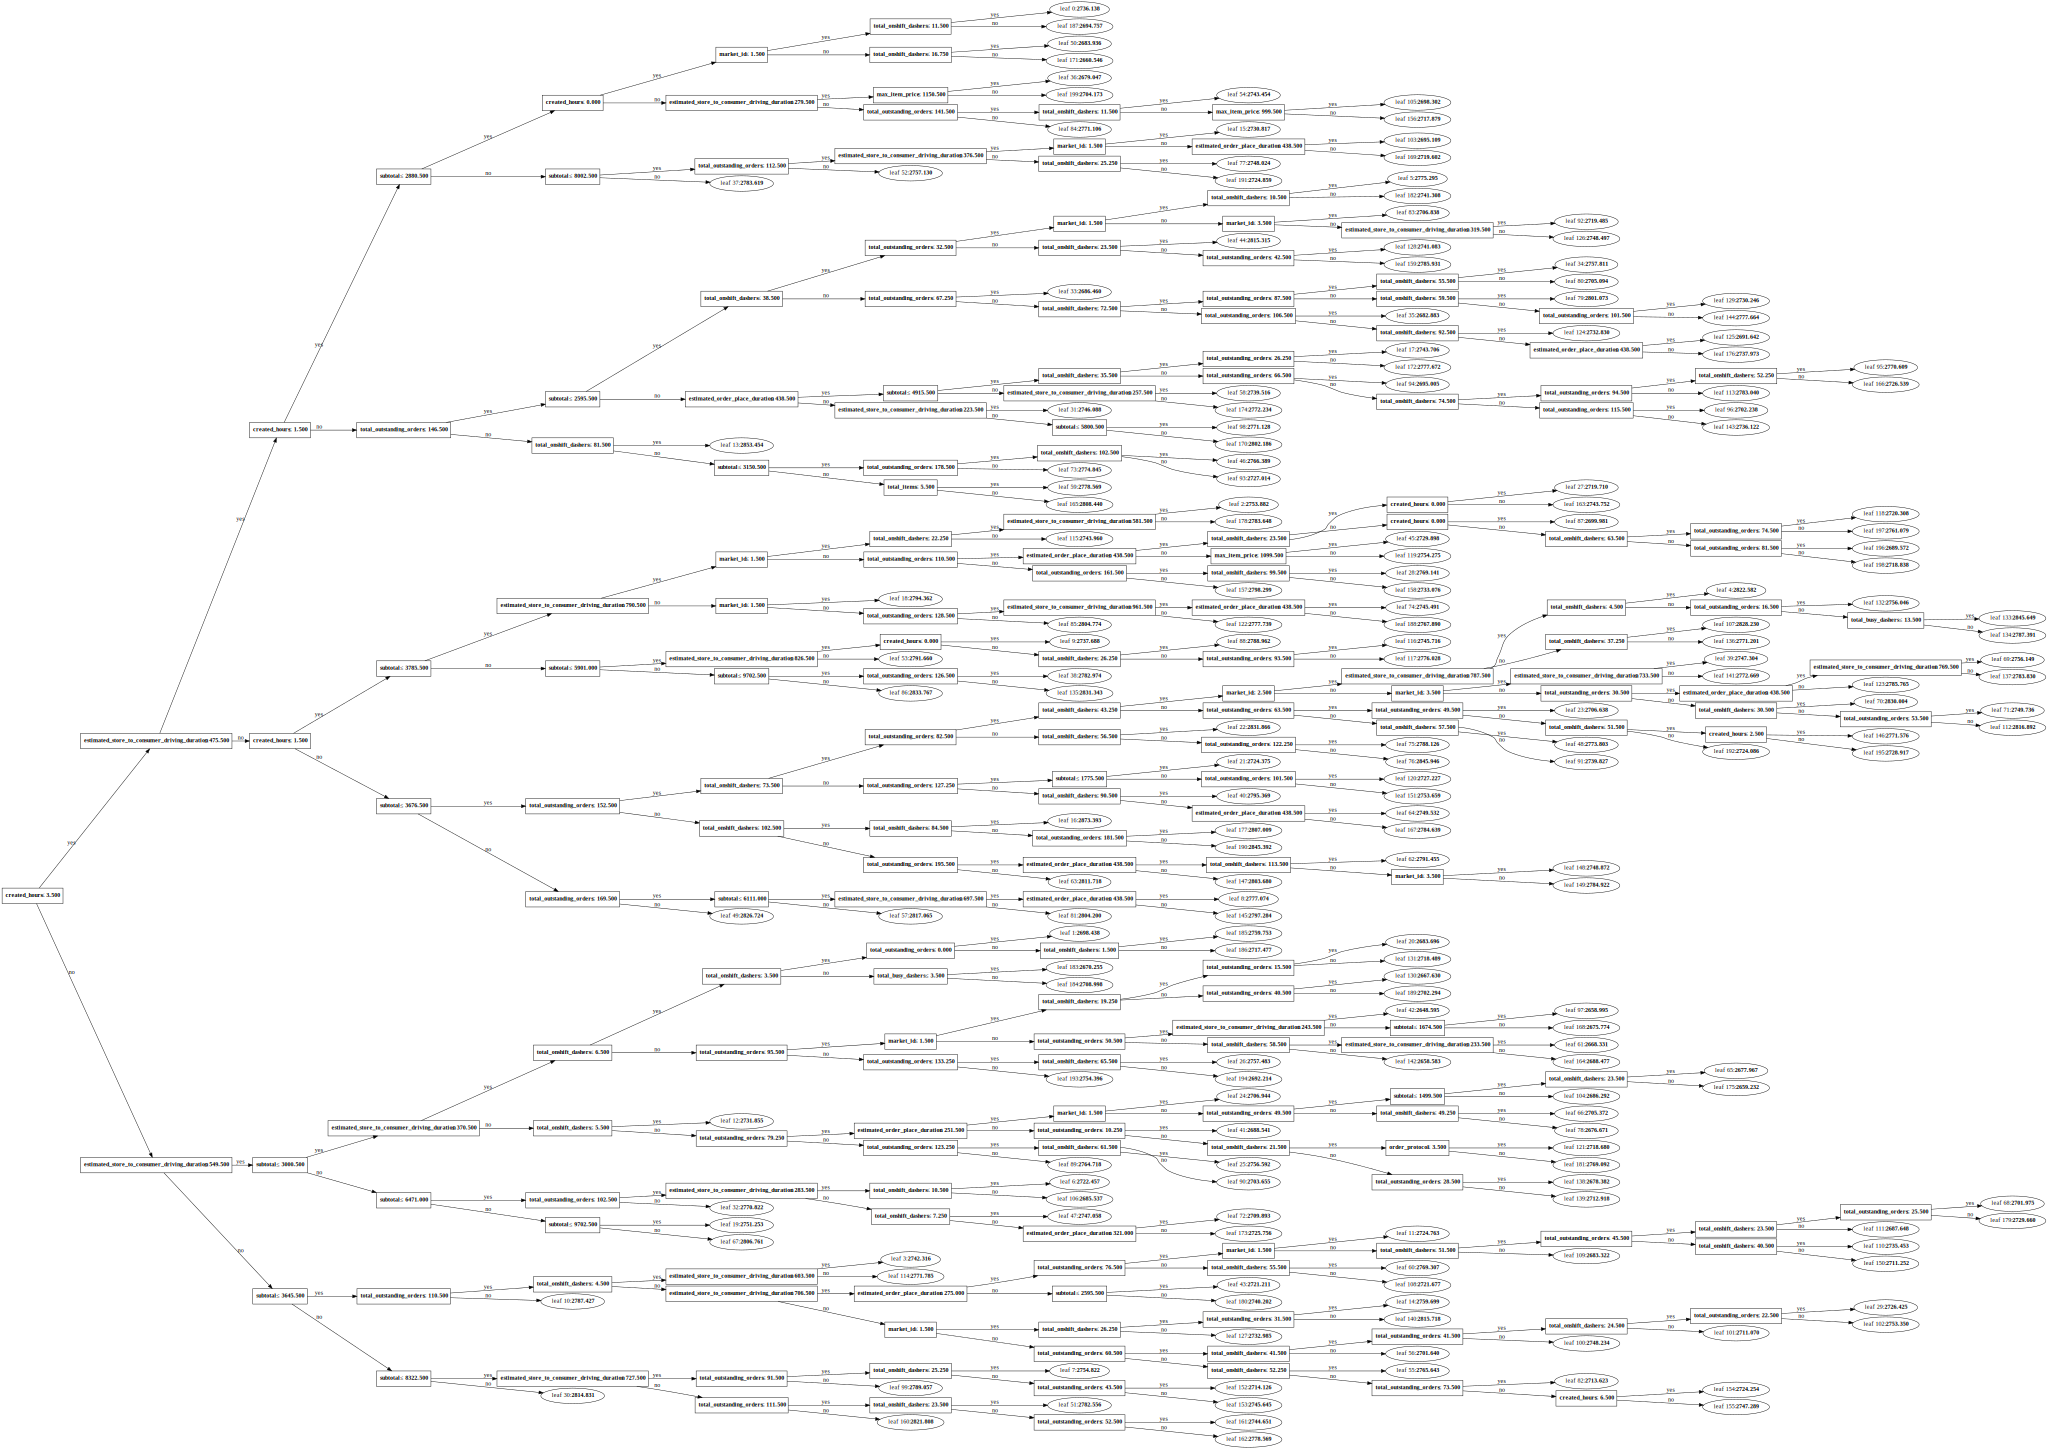

In [51]:
lgb.create_tree_digraph(best_lgb_ro)

In [52]:
print(f'Test RMSE = {rmse(best_lgb_ro.predict(preprocess_pipe.transform(X_test)), y_test)}')

Test RMSE = 975.8179862019873


d:\Data Science 101\StrataScratch Projects\Delivery Duration Prediction\imputers.py:66: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X[feature] = X[feature].fillna(self.nearest[feature], downcast='infer')


# Saving model

From the analysis, we have the test set RMSE as follows:

- Base Model: 963.0338172292286
- Base Model with outliers removed: 974.9839101593617
- LGB with BayesCV: 956.1083487312169
- LGB with BayesCV and removing outliers: 975.8179862019873

So we shall choose LGB with BayesCV as the model of choice.

In [58]:
final_model = lgb.LGBMRegressor(
    colsample_bytree=0.700757141907958,
    max_depth=13,
    min_child_samples=75,
    min_split_gain=0.5,
    num_leaves=200,
    reg_alpha=1.0,
    reg_lambda=1.0,
    subsample=1.0,
    subsample_freq=50,
    random_state=1048576, 
    verbose=-1)

final_model.fit(X_train_preprocessed, y_train)

save_path = 'lgb_with_bayesCV.txt'
final_model.booster_.save_model(save_path)

print(f'Model saved as {save_path}')


Model saved as lgb_with_bayesCV.txt
